# Projet Data Science - Banklytics

## Use case

Banklytics est une banque nord-américaine reconnue pour sa solidité, sa transparence et sa rigueur dans la gestion du risque. Acteur de référence sur le marché des prêts hypothécaires, l’établissement s’engage dans une démarche d’amélioration continue de ses processus d’octroi, en s’appuyant sur des outils technologiques fiables et éthiquement responsables. Dans cette optique, la banque souhaite renforcer sa capacité à évaluer, de manière objective et reproductible, la valeur des biens immobiliers proposés en garantie par les emprunteurs.

Pour répondre à cet enjeu, une solution d’apprentissage automatique supervisé a été développée afin d’estimer le prix de marché d’un bien immobilier à partir de ses caractéristiques observables : surface habitable, qualité des matériaux, année de construction, emplacement, etc. Le modèle repose sur un algorithme de régression (XGBoost), entraîné sur un jeu de données publics structuré et anonymisé (Ames Housing Dataset). La prédiction est réalisée à partir de variables disponibles au moment de la demande, avec un traitement automatisé incluant l’imputation des valeurs manquantes, l’encodage des variables catégorielles et l’application de transformations log pour limiter les distorsions liées aux extrêmes.

L’estimation obtenue est intégrée de manière transparente dans le workflow des analystes d’octroi de crédit, via une interface interne ou un export Excel enrichi. Elle sert de point de référence neutre permettant de détecter rapidement d’éventuels écarts entre le prix de vente déclaré par le client et la valeur prédite. Des marges d’acceptabilité configurables (par exemple ±10 %) sont prévues pour déclencher des alertes lorsque l’écart devient significatif (ex. > 20 %), tout en laissant à l’analyste la pleine responsabilité de la décision. Aucune action automatique n’est engagée sans validation humaine. L’objectif est d’assister la prise de décision sans l’automatiser, dans un souci de traçabilité, de maîtrise du risque et de conformité réglementaire.

Afin d’assurer la robustesse du système, la performance du modèle est évaluée à l’aide de la métrique RMSLE, particulièrement adaptée à la nature logarithmique et asymétrique des prix immobiliers. La surveillance est effectuée mensuellement, avec un suivi par segment (quartier, type de bien) et une attention particulière portée à la détection de biais systématiques. Le modèle est mis à jour trimestriellement ou en cas de dérive, selon un processus documenté, reproductible et conforme aux exigences d’auditabilité interne.

L’approche adoptée par Banklytics respecte les principes fondamentaux de l’IA éthique : absence de données personnelles, transparence des calculs, non-discrimination indirecte et validation humaine obligatoire. Ce dispositif permet à la banque d’améliorer la cohérence, l’objectivité et la fiabilité de son analyse du risque tout en restant alignée avec les exigences légales, prudentielles et déontologiques en vigueur.

Vous trouverez ci-dessus le Machine Learning Canvas, qui synthétise de manière structurée l’intégration du modèle prédictif au sein de notre processus d’octroi de crédit. Il décrit les éléments essentiels du dispositif, depuis la collecte des données jusqu’au monitoring post-déploiement, en passant par les objectifs métier, les modalités de décision, les sources utilisées, les approches de collecte de données et les mécanismes de contrôle de la performance et de l’équité. Ce canevas constitue une base de référence claire et cohérente pour assurer l’alignement du projet avec les impératifs opérationnels, techniques et réglementaires de la banque.

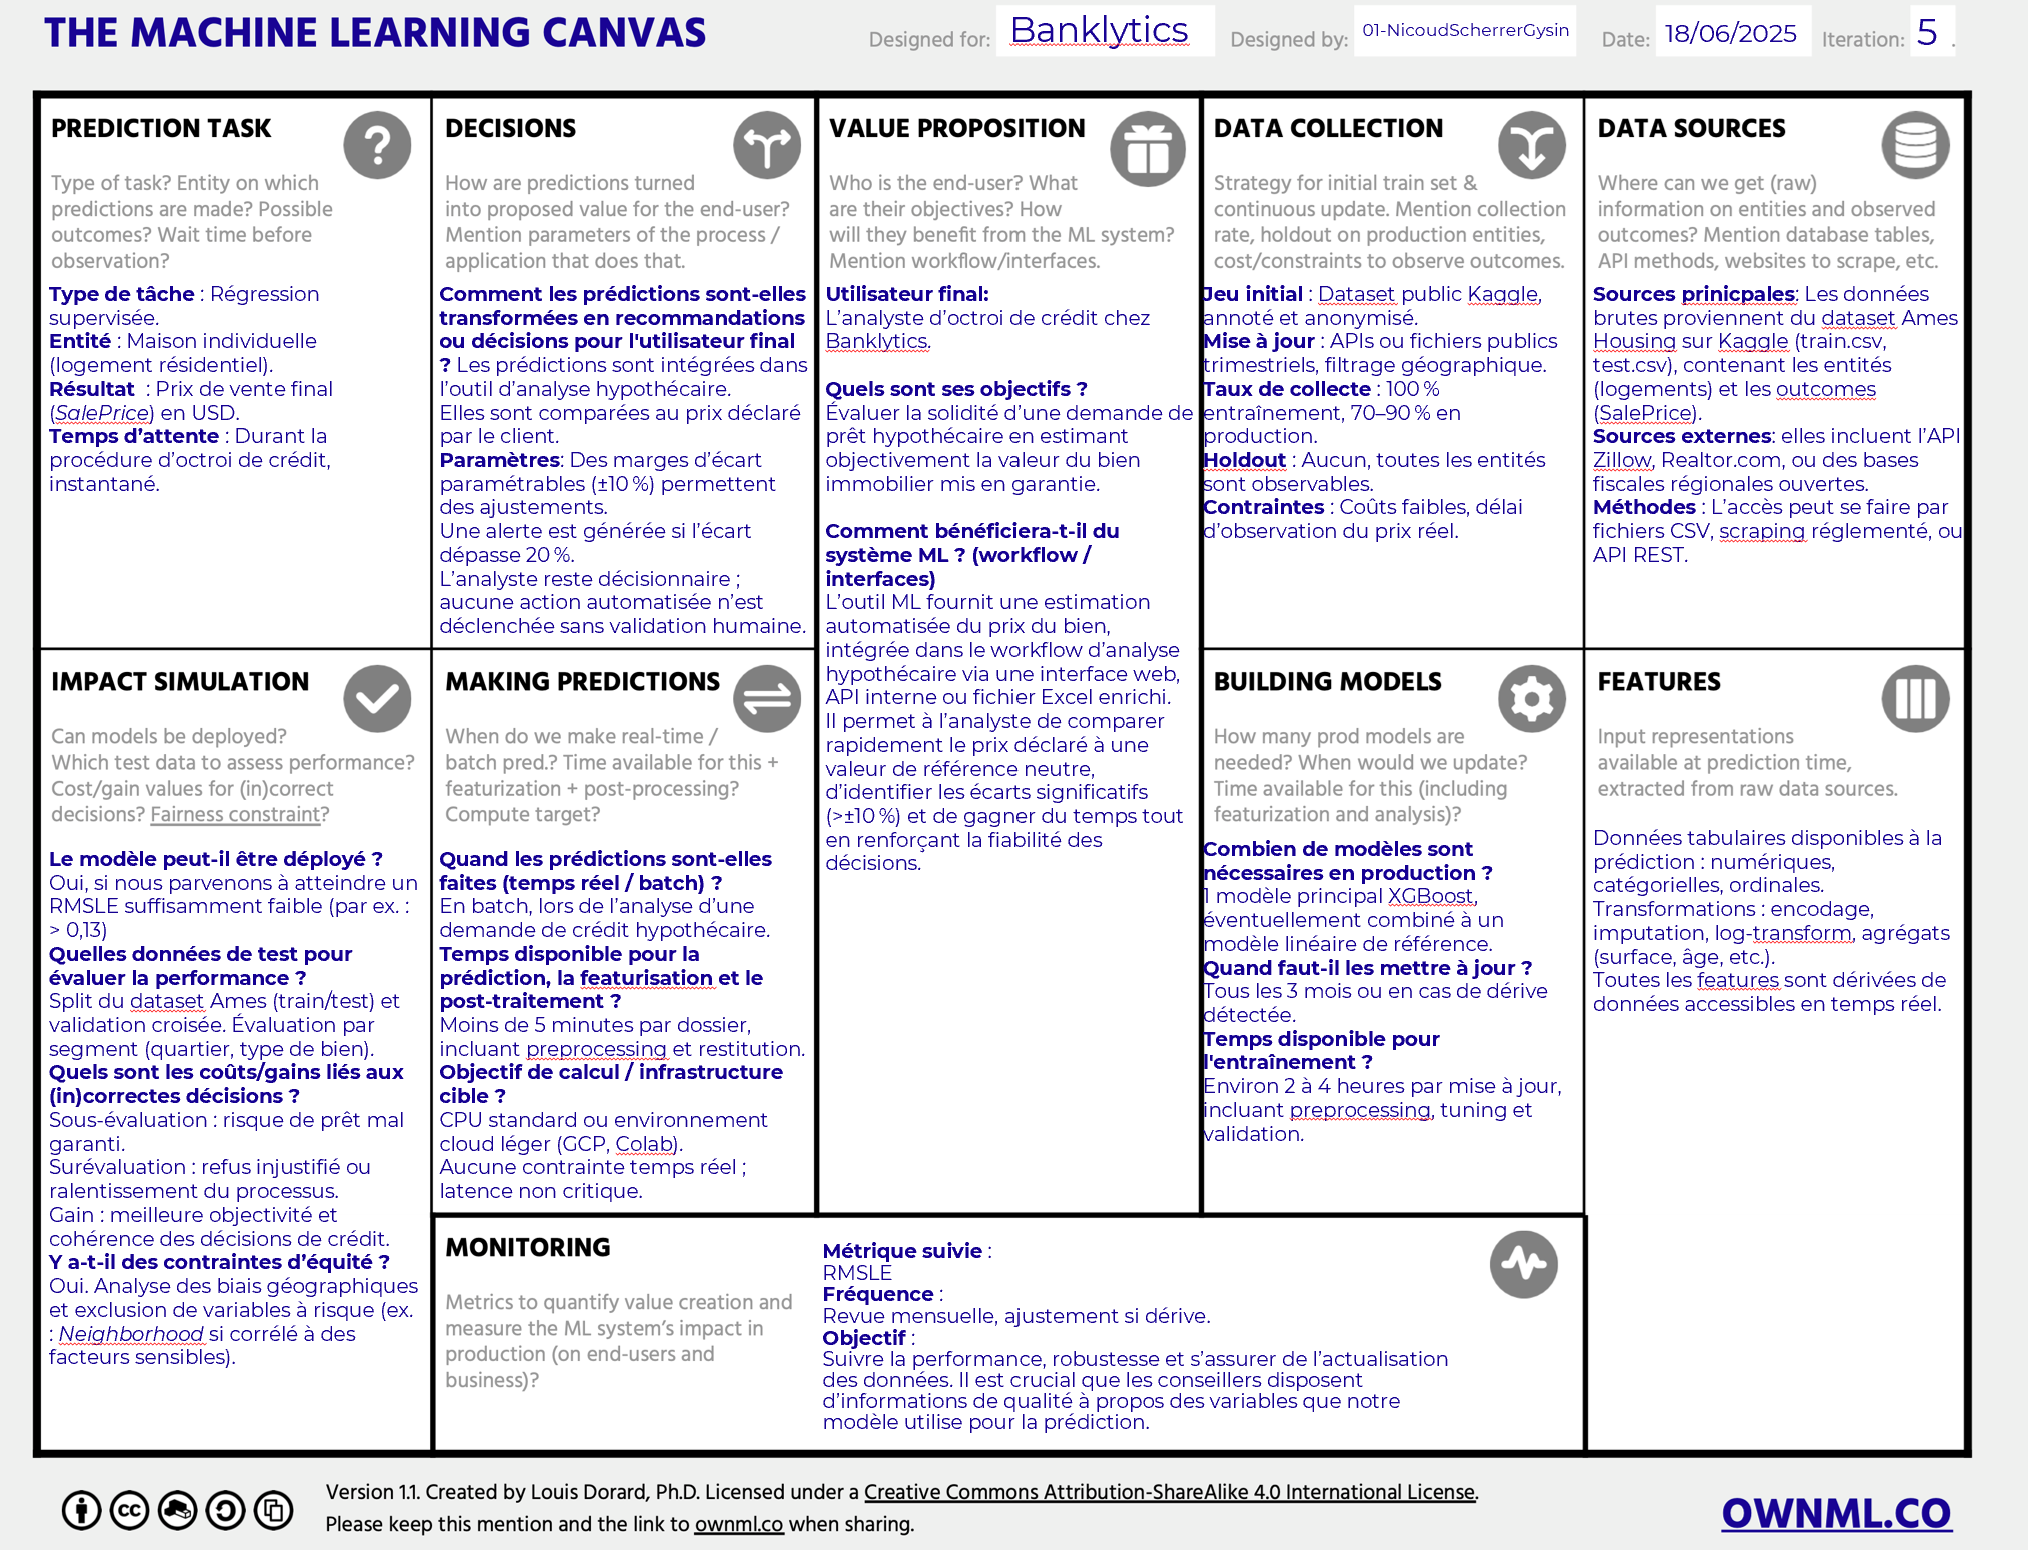

## Compréhension métier et des données
Lorsqu’un client sollicite un prêt hypothécaire, il nous transmet un dossier technique détaillé du bien concerné. Notre ambition est de compléter l’analyse de nos experts par un modèle automatisé, capable d’estimer avec précision la valeur du bien sur la base de ses attributs clés (surface, nombre de pièces, localisation, état général, etc.).

Afin d’évaluer la faisabilité de cette approche, nous utilisons un jeu de données de référence, disponible publiquement sur Kaggle, portant sur la ville d’Ames (Iowa, États-Unis). Ce dataset, couvrant la période 2006–2010, offre un ensemble riche de variables techniques et contextuelles sur plusieurs centaines de transactions immobilières.

Bien que ces données ne soient pas récentes, elles constituent une base d’expérimentation pertinente pour tester la robustesse et la performance de différents algorithmes de régression. Si les résultats s’avèrent satisfaisants, une seconde phase du projet consistera à constituer un jeu de données plus actuel et représentatif de notre marché cible, en vue d’un déploiement opérationnel.

## Importation des données et des librairies

In [186]:
# python -m venv .venv
# source .venv/bin/activate
# pip install -r requirements.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

plt.style.use('seaborn-v0_8')

In [187]:
# Data loading
train_raw = pd.read_csv('train.csv', index_col = 'Id')
validation_raw = pd.read_csv('test.csv', index_col = 'Id')

## Fonctions diverses

Fonctions diverses utilisées au fil de l'analyse. Ce projet est inspiré des exemples et ressources fournies dans le carde du cours de data science : https://github.com/kiwil87/64-61.1-Data-Science

In [188]:
# Fill empty values with a constant to avoid NaN issues in calculations
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [189]:
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [190]:
# For date variables, we will fill the missing values using the values from another column
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

In [191]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [192]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [193]:
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

In [194]:
def scatter_plots(y, X, features) :
    
    for f in features :
        x = X[f]
        
        plt.title('Correlation ' + y.name + ' & ' + x.name)
        sns.regplot(x = x.name, y = y.name, data = pd.concat([x, y], axis = 1), x_jitter = .05)
        
        plt.show()

In [195]:
def anova(y, X, features):
    
    anova = pd.DataFrame()
    anova['feature'] = features
    pvals = []
    
    for f in features:
        
        samples = []
        
        for cls in X[f].unique():
            
            s = y[X[f] == cls].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
        
    anova['pval'] = pvals
    anova = anova.sort_values('pval')
    
    anova['disparity'] = np.log(1. / anova['pval'].values)

    sns.barplot(data = anova, x = 'feature', y = 'disparity')
    x = plt.xticks(rotation=90)
    
    return anova

In [196]:
def box_plots(y, X, features) :
    
    for f in features :
        x = X[f]
    
        plt.title('Box plot ' + y.name + ' & ' + x.name)
        sns.boxplot(x = x, y = y)
        x = plt.xticks(rotation = 90)
        
        plt.show()

In [197]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [198]:
from statsmodels.graphics.gofplots import ProbPlot
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]));
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel(r'$\sqrt{|Standardized Residuals|}$');
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]));
    
    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]));
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

In [199]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

In [200]:
def plot_prediction(actual, predicted) :
    
    data = pd.concat([actual, predicted], keys = ['actual', 'predicted'], axis = 1)

    plt.title('Actual vs Predicted')
    sns.regplot(x = 'actual', y = 'predicted', data = data)
    plt.show()

In [201]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

def rmsle(actual, predicted):
    return np.sqrt(np.mean((np.log1p(actual) - np.log1p(predicted)) ** 2))

In [202]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
               'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
               'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
               'MiscFeature', 'SaleType', 'SaleCondition', 'YrSold', 'MoSold']

numeric = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
           'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']




### Variables choices

## Baseline model engineering


In [203]:
train_raw['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

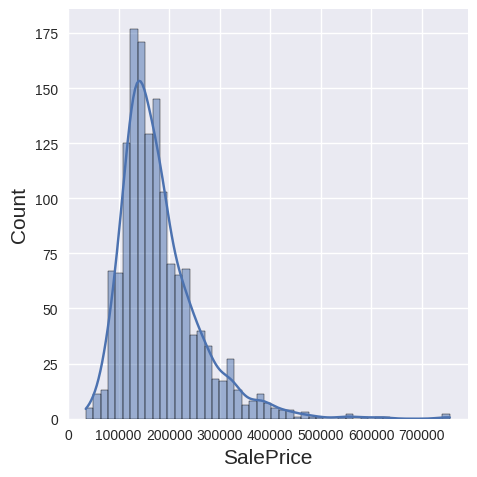

In [204]:
# distribution plot with normal fit
ax = sns.displot(data = train_raw['SalePrice'], kde=True)
plt.show()

Les prix de ventes affichés ci-dessus ont l'air normalement distribué nous allons cependant effectuer un test de Shapiro-Wilk afin de confirmer cette hypothèse.

The assocated p-value is : 3.2061412312021656e-33
With a threshold α = 0.05, we reject the null hypothesis


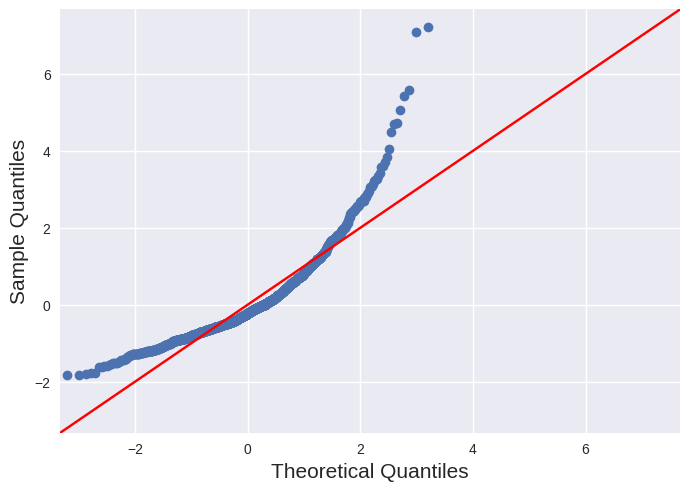

In [205]:
alpha = 0.05
W, p = stats.shapiro(train_raw['SalePrice'])

print('The assocated p-value is : ' + str(p))

if p < alpha : 
    print('With a threshold α = ' + str(alpha) + ', we reject the null hypothesis')
else : 
    print('With a threshold α = ' + str(alpha) + ', we fail to reject the null hypothesis')
    
qqplot(train_raw['SalePrice'], dist = stats.distributions.norm, fit = True, line = '45')
plt.show()

Nous voyons donc que l'hypothèse nulle est rejeté et donc que les données ne sont pas normalement distribué. En effectuant quelques autres analyses, nous voyons que les données suivent plutôt une échelle logarithmique. Grâce au Q-Q plot ci-dessous, nous confirmons cette théorie.

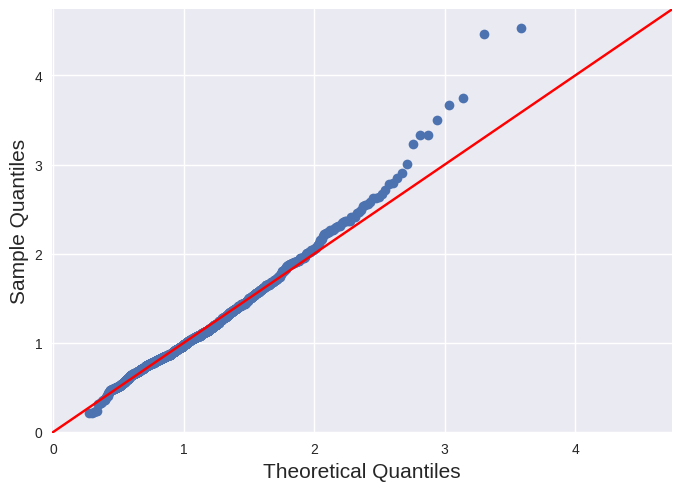

In [206]:
qqplot(train_raw['SalePrice'], dist = stats.distributions.lognorm, fit = True, line = '45')
plt.show()

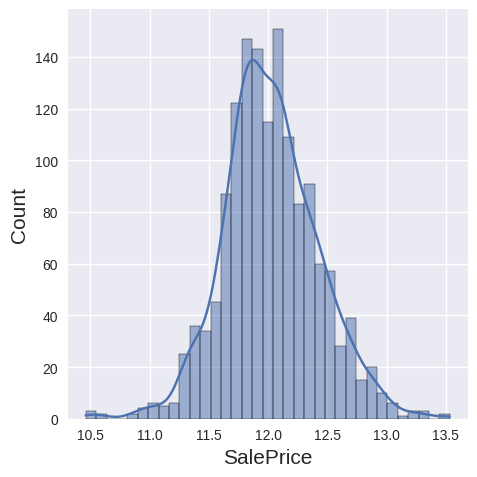

In [207]:
# new variable target which is the logarithm of the SalePrice
target = np.log1p(train_raw['SalePrice'])

# distribution plot
ax = sns.displot(data = target, kde=True)
plt.show()

Nous voyons donc qu'après la transformation avec la fonction log1p, les données sont donc réparties normalement


## Model enginering

### Nettoyage des données


Afin de pouvoir utiliser les données correctement, nous devons les "nettoyer". Il faut remplir les données vides et transformer les données "dates" en valeur chiffrée afin de pouvoir les utiliser. Nous avons donc séparé les données en trois catégories (Qualitative, Quantitative et Date). Nous remplaçons donc les valeurs manquantes par 0 pour les quantitatives, NA pour les qualitative et les champs dates.

In [208]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

In [209]:
data_raw = pd.concat([train_raw, validation_raw])

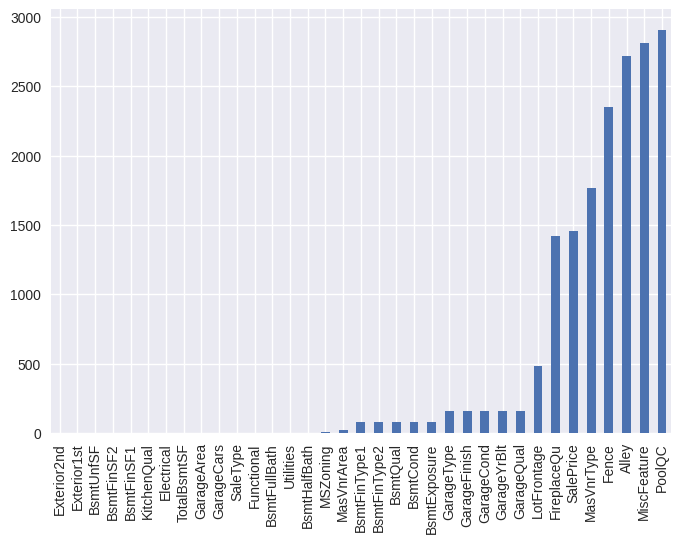

In [210]:
plot_missing(data_raw)

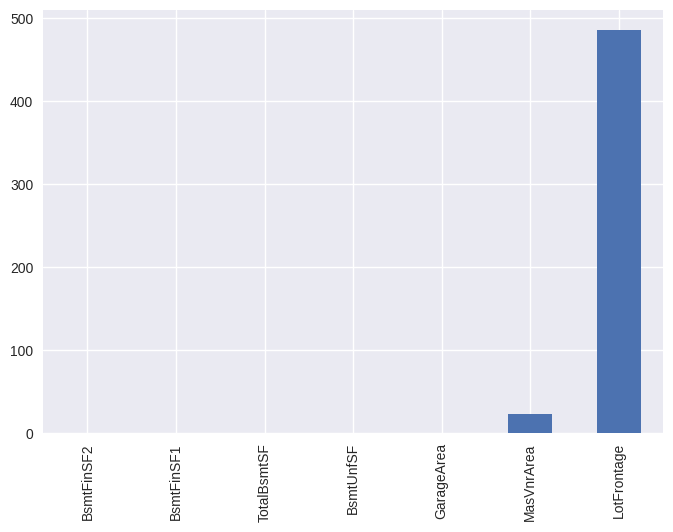

In [211]:
plot_missing(data_raw[quantitative])

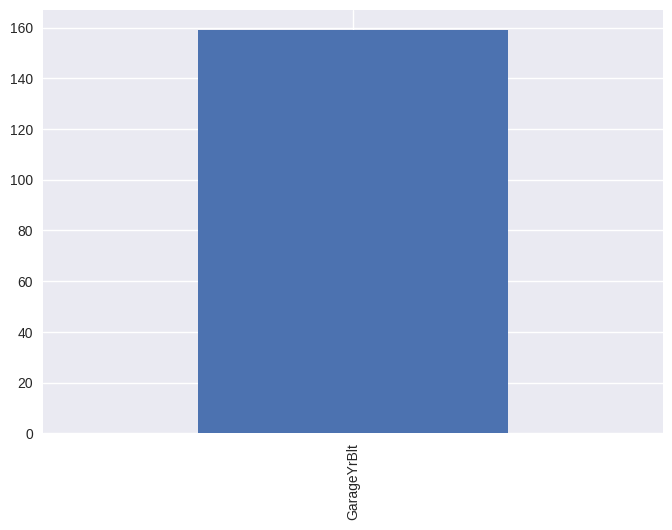

In [212]:
plot_missing(data_raw[date])

In [213]:
data_clean = clean(data_raw)

data_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0


### Base Pipeline

In [214]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
               'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
               'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
               'MiscFeature', 'SaleType', 'SaleCondition', 'YrSold', 'MoSold']

numeric = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
           'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

# Split of the clean dataset into train & validation
train_clean = data_clean[data_clean.index.isin(train_raw.index)]
validation_clean = data_clean[data_clean.index.isin(validation_raw.index)]

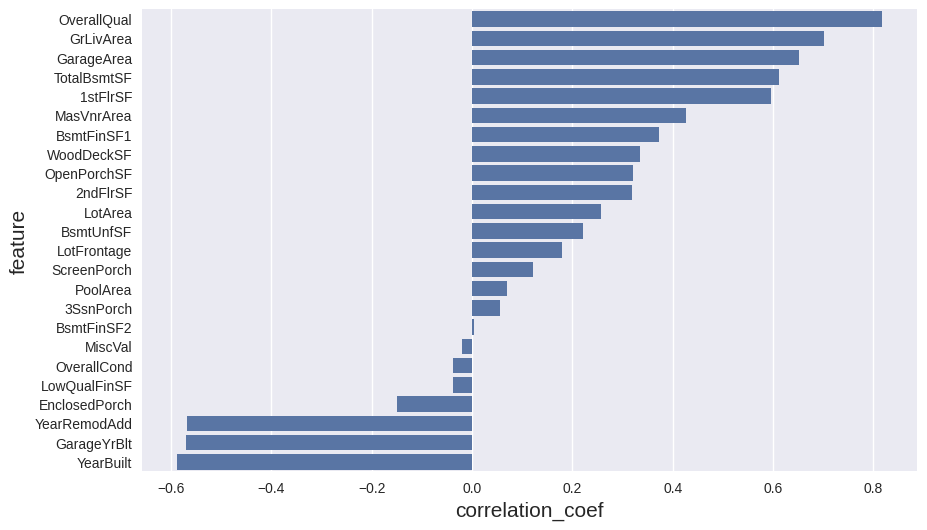

In [215]:
cor = correlation(target, train_clean, numeric, method = 'pearson')

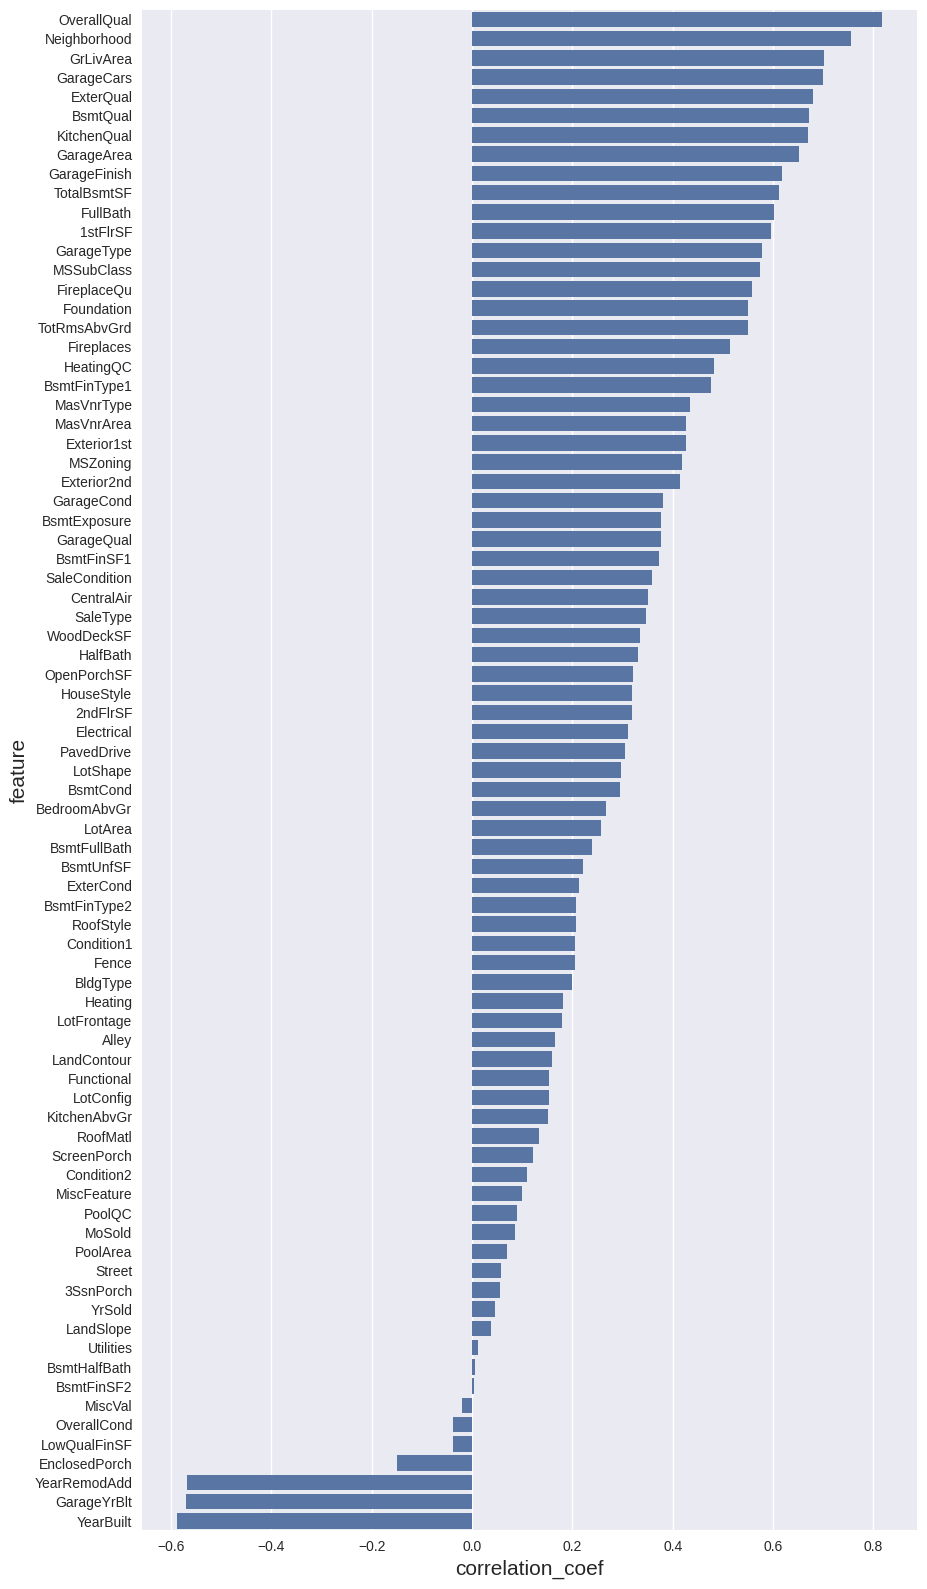

In [216]:
data_preprocess = encode_with_mean(data_clean, target, categorical)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_raw.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(validation_raw.index)]

cor = correlation(target, train_preprocess, numeric + categorical)

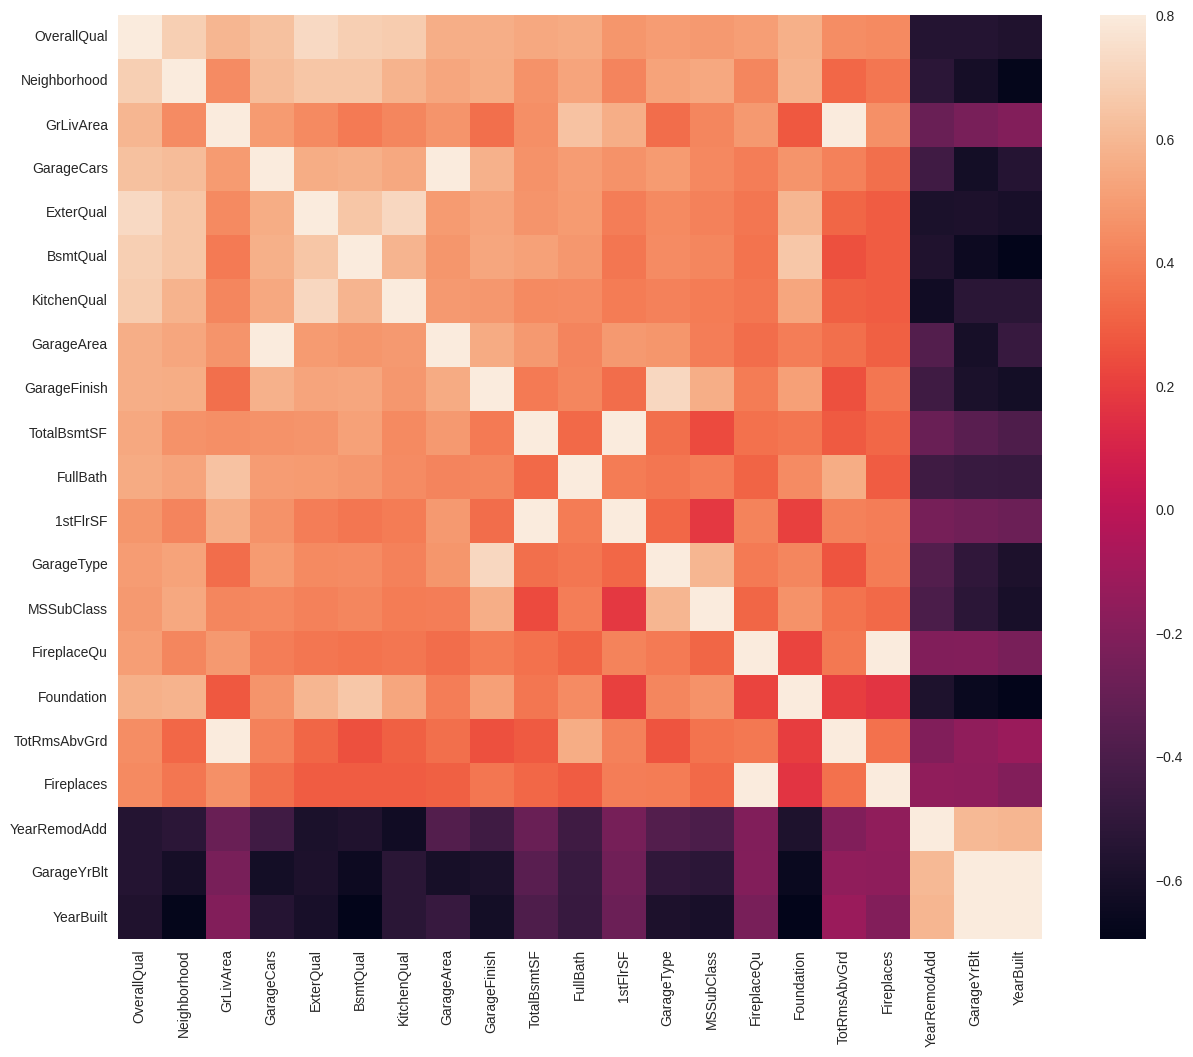

In [217]:
cols = cor[abs(cor['correlation_coef']) > 0.5]['feature'].tolist()
correlation_matrix = train_preprocess[cols].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

Pour la baseline, nous avons choisi d'utiliser le modèle et les colonnes basiques fournis dans le cours.

In [218]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [219]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:02   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.



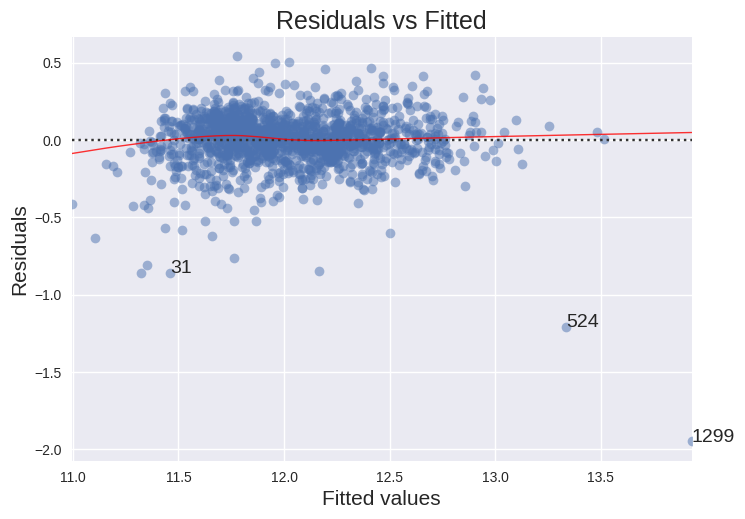

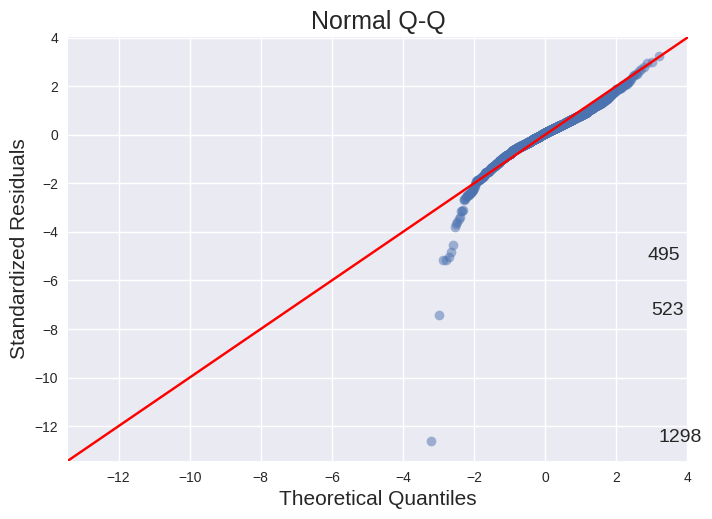

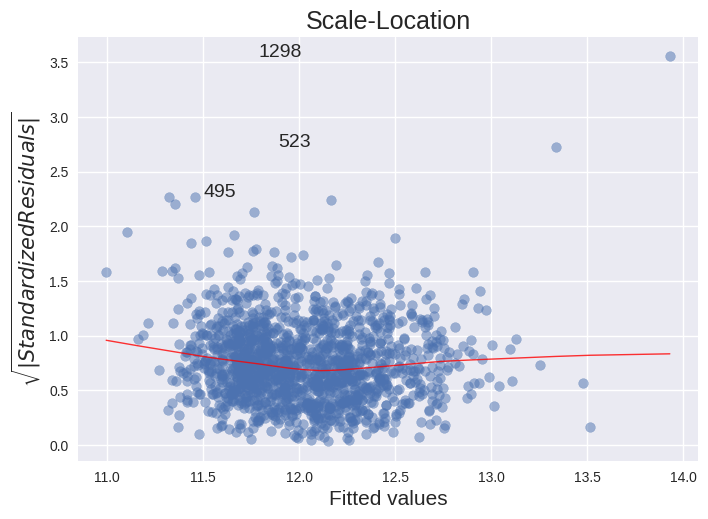

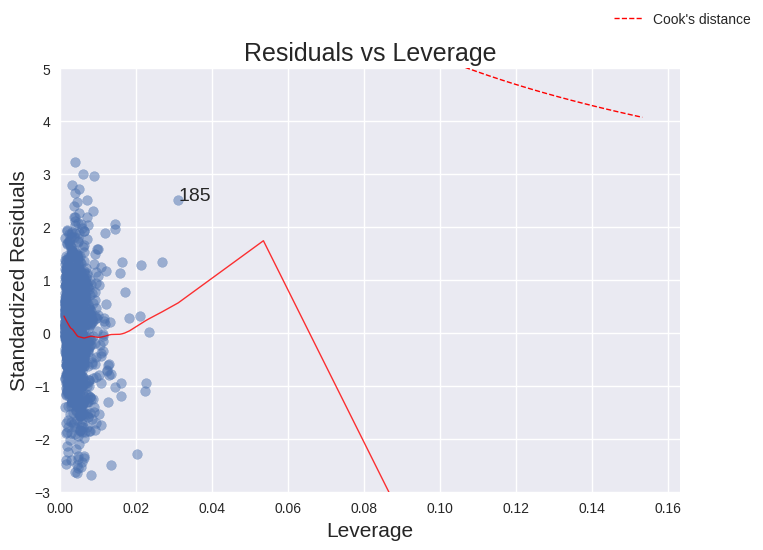

In [220]:
diagnostic_plots(sm.add_constant(X), y)

In [221]:
print(X[base].iloc[[523, 1298]])

      OverallQual  Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                                
524            10     11.712321       4676       3138.0          0
1299           10     11.712321       5642       6110.0          0


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:03   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.



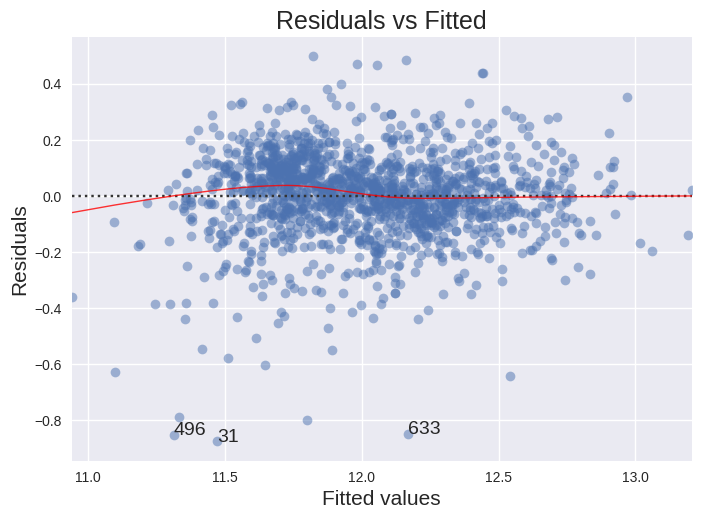

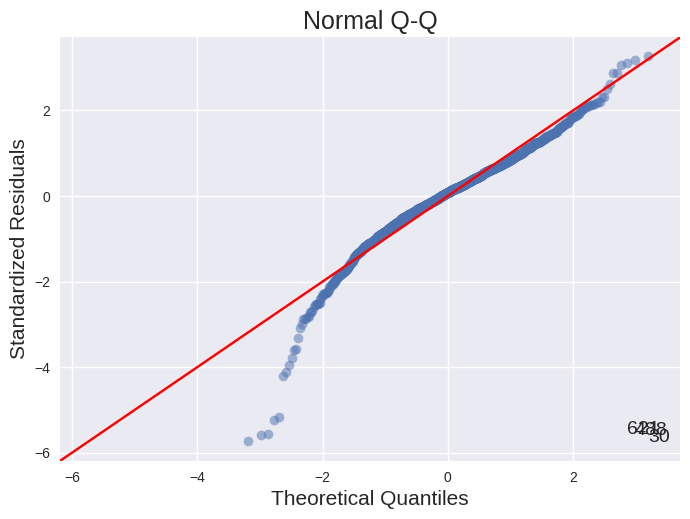

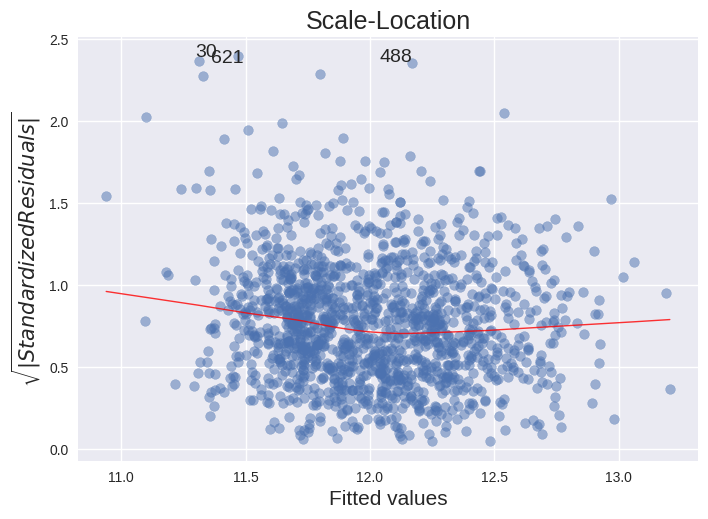

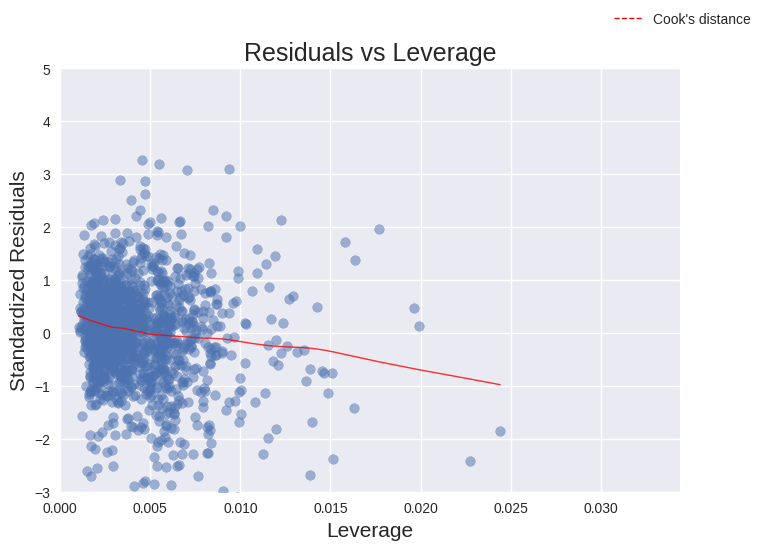

In [222]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

In [223]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.214534
2    12.081588
3    12.244451
4    12.046219
5    12.620316
dtype: float64


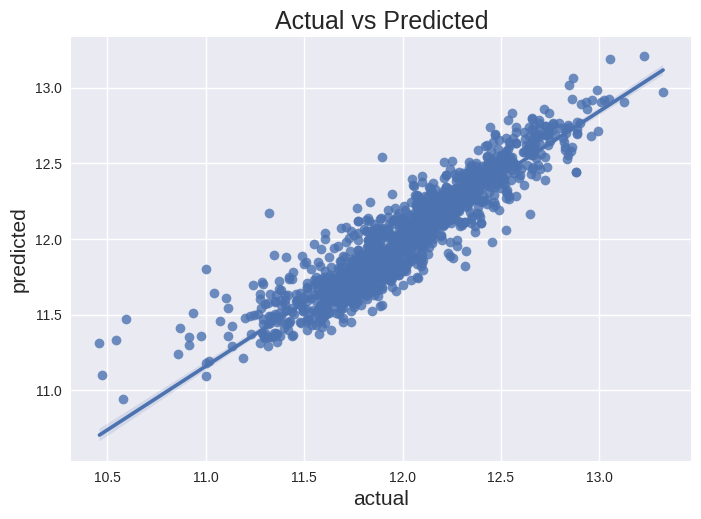

In [224]:
plot_prediction(y, y_pred)

In [225]:
print('Root Mean Square Error (RMSLE) :', rmsle(y, y_pred))

Root Mean Square Error (RMSLE) : 0.01189757184007072


In [226]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.663271
1462    11.946171
1463    12.025787
1464    12.101195
1465    12.341289
dtype: float64


In [227]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('baseline.csv', index = False)

Note obtenue sur Kaggle : 0.16913

### Model 1 - régression

Régression linéaire avec 10 colonnes triées et sélectionnées en fonction de notre cas métier.

Nous avons cherché des variables qui sont présentes sur les annonces régulièrement. En effet, pour que nos analystes puissent bénéficier de bonnes prédictions, il faut que nous utilisions des variables qu'ils peuvent facilement obtenir et renseigner. Ces variables sont assez standard et faciles à obtenir (bon taux de présence sur les annonces).
De plus, ces variables représentent des critères communément utilisés pour décrire des biens immobiliers, il semble donc intéressant de les explorer en priorité pour voir les résultats de prédiction envisageables.

Nous avons alors retenu comme premier set de variables :
- OverallQual : Qualité générale
- OverallCond : Condition générale
- Neighborhood : Quartier
- GrLivArea : Superficie de l'habitation
- LotArea : Superficie du terrain
- YearBuilt : Année de construction
- Foundation : Type de fondation
- TotRmsAbvGrd : Nombre de chambres, salles de bain exclues
- GarageArea : Taille du garage
- PoolArea : Taille de la piscine, 0 si pas à vérifier la pertinence


In [228]:
base = [
    "OverallQual",
    "OverallCond",
    "Neighborhood",
    "GrLivArea",
    "LotArea",
    "YearBuilt",
    "Foundation",
    "TotRmsAbvGrd",
    "GarageArea",
    "PoolArea",
]

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [229]:
lasso_alphas = 10**np.linspace(-6,0,100)
lasso_alphas

array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-05, 2.15443469e-05, 2.47707636e-05,
       2.84803587e-05, 3.27454916e-05, 3.76493581e-05, 4.32876128e-05,
       4.97702356e-05, 5.72236766e-05, 6.57933225e-05, 7.56463328e-05,
       8.69749003e-05, 1.00000000e-04, 1.14975700e-04, 1.32194115e-04,
       1.51991108e-04, 1.74752840e-04, 2.00923300e-04, 2.31012970e-04,
       2.65608778e-04, 3.05385551e-04, 3.51119173e-04, 4.03701726e-04,
       4.64158883e-04, 5.33669923e-04, 6.13590727e-04, 7.05480231e-04,
       8.11130831e-04, 9.32603347e-04, 1.07226722e-03, 1.23284674e-03,
       1.41747416e-03, 1.62975083e-03, 1.87381742e-03, 2.15443469e-03,
      

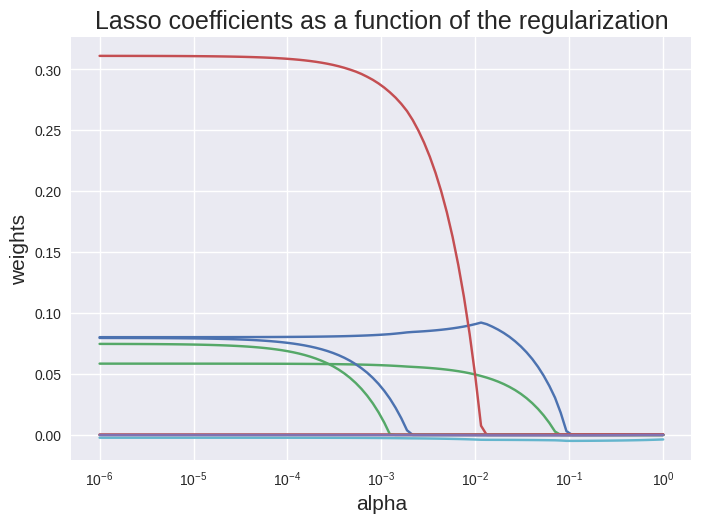

In [230]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso_regression = Lasso(max_iter=10000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X, y)
    lasso_coefs.append(lasso_regression.coef_)
    lasso_cv.append(cross_val_score(lasso_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

# Show the plot
plt.show()

In [231]:
ridge_alphas = 10**np.linspace(-3,5,100)
ridge_alphas

array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-02, 3.43046929e-02,
       4.13201240e-02, 4.97702356e-02, 5.99484250e-02, 7.22080902e-02,
       8.69749003e-02, 1.04761575e-01, 1.26185688e-01, 1.51991108e-01,
       1.83073828e-01, 2.20513074e-01, 2.65608778e-01, 3.19926714e-01,
       3.85352859e-01, 4.64158883e-01, 5.59081018e-01, 6.73415066e-01,
       8.11130831e-01, 9.77009957e-01, 1.17681195e+00, 1.41747416e+00,
       1.70735265e+00, 2.05651231e+00, 2.47707636e+00, 2.98364724e+00,
       3.59381366e+00, 4.32876128e+00, 5.21400829e+00, 6.28029144e+00,
       7.56463328e+00, 9.11162756e+00, 1.09749877e+01, 1.32194115e+01,
       1.59228279e+01, 1.91791026e+01, 2.31012970e+01, 2.78255940e+01,
      

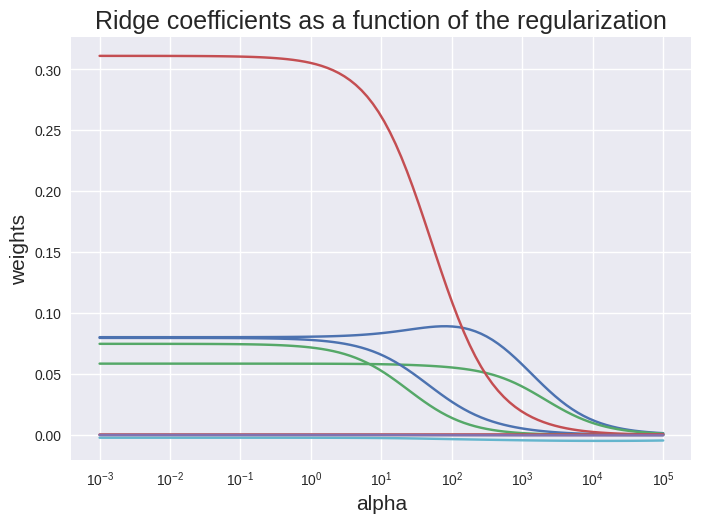

In [232]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge()
ridge_coefs = []
ridge_cv = []

for alpha in ridge_alphas:
    ridge_regression.set_params(alpha=alpha)
    ridge_regression.fit(X, y)
    ridge_coefs.append(ridge_regression.coef_)
    ridge_cv.append(cross_val_score(ridge_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(ridge_alphas, ridge_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

# Show the plot
plt.show()

In [233]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     839.8
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:09   Log-Likelihood:                 667.53
No. Observations:                1460   AIC:                            -1313.
Df Residuals:                    1449   BIC:                            -1255.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.2170      0.533      9.787   

In [234]:
print(X[base].iloc[[523, 1298]])

      OverallQual  OverallCond  Neighborhood  GrLivArea  LotArea  YearBuilt  \
Id                                                                            
524            10            5     11.712321       4676    40094          0   
1299           10            5     11.712321       5642    63887          0   

      Foundation  TotRmsAbvGrd  GarageArea  PoolArea  
Id                                                    
524     12.26167     12.549248       884.0         0  
1299    12.26167     12.412001      1418.0       480  


In [235]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     891.6
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:09   Log-Likelihood:                 758.55
No. Observations:                1429   AIC:                            -1495.
Df Residuals:                    1418   BIC:                            -1437.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.1343      0.525     13.594   

In [236]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.262324
2    12.161443
3    12.312840
4    12.033965
5    12.690637
dtype: float64


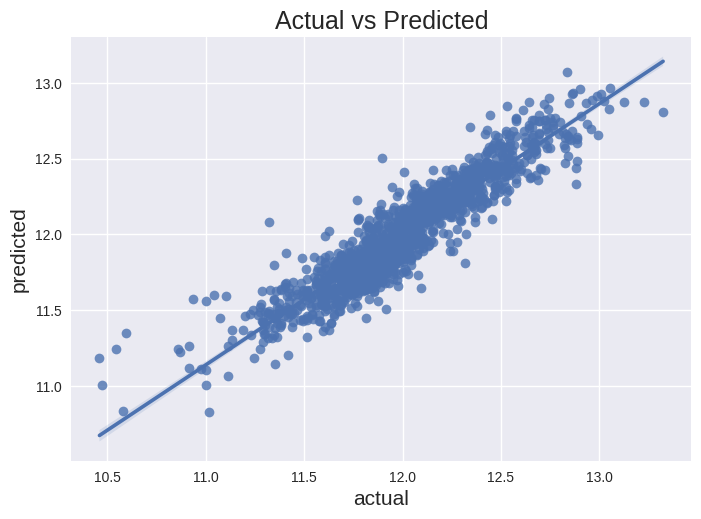

In [237]:
plot_prediction(y, y_pred)

In [238]:
print('Root Mean Square Error (RMSLE) :', rmsle(y, y_pred))

Root Mean Square Error (RMSLE) : 0.011049718982094987


In [239]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.777543
1462    11.873634
1463    12.068405
1464    12.178777
1465    12.271600
dtype: float64


In [240]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('regression_linear_10_columns.csv', index = False)

Note obtenue sur Kaggle : 0.15715

On retire la colonne de la piscine car elle semble peu pertinente (très peu de data)

In [241]:
base = ['OverallQual', 'OverallCond', 'Neighborhood', 'GrLivArea', 'LotArea', 'YearBuilt', 'Foundation','TotRmsAbvGrd',
        'GarageArea']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [242]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     932.4
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:09   Log-Likelihood:                 666.61
No. Observations:                1460   AIC:                            -1313.
Df Residuals:                    1450   BIC:                            -1260.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1085      0.527      9.691   

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.



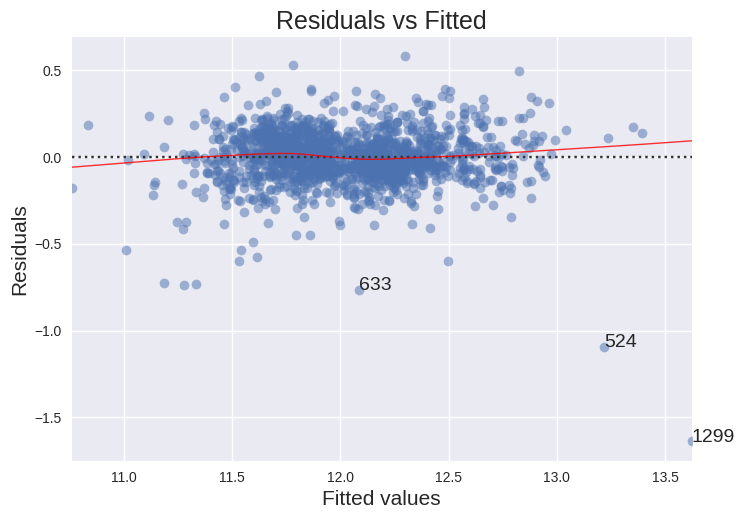

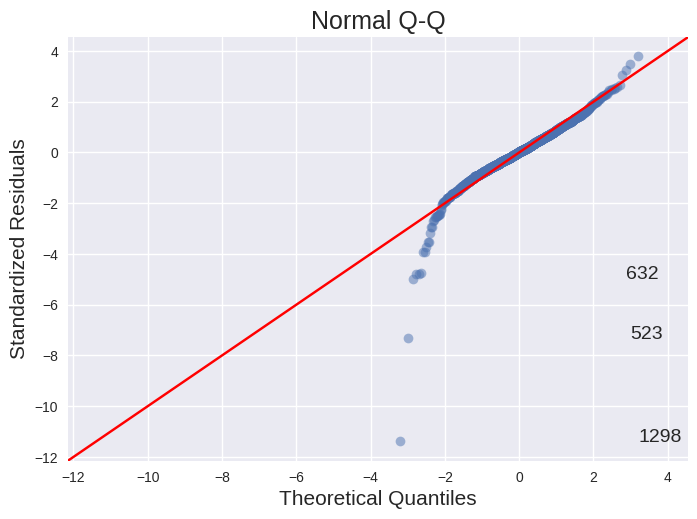

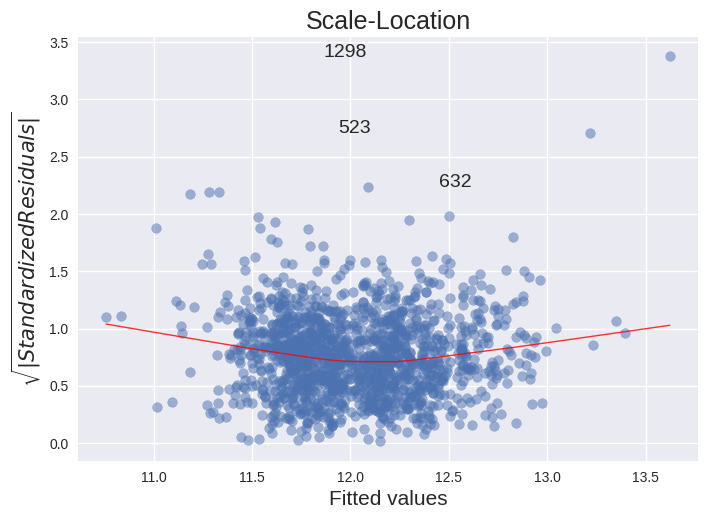

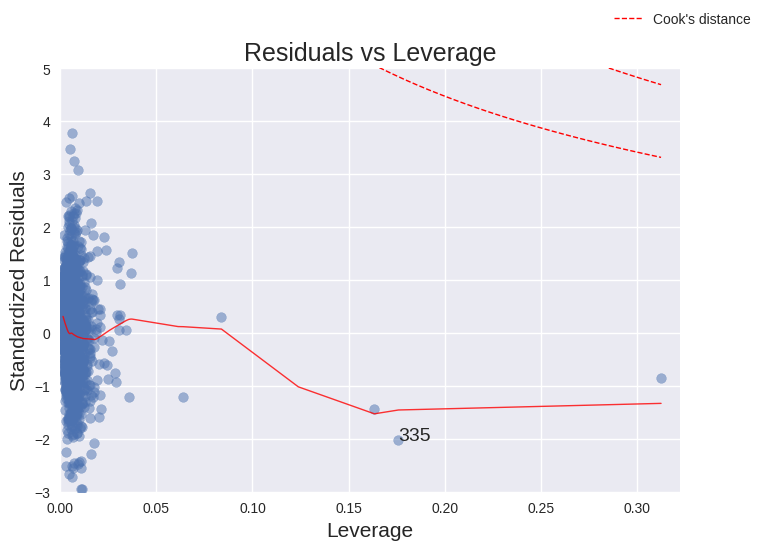

In [243]:
diagnostic_plots(sm.add_constant(X), y)

In [244]:
print(X[base].iloc[[523, 1298]])

      OverallQual  OverallCond  Neighborhood  GrLivArea  LotArea  YearBuilt  \
Id                                                                            
524            10            5     11.712321       4676    40094          0   
1299           10            5     11.712321       5642    63887          0   

      Foundation  TotRmsAbvGrd  GarageArea  
Id                                          
524     12.26167     12.549248       884.0  
1299    12.26167     12.412001      1418.0  


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     987.0
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:28:09   Log-Likelihood:                 755.84
No. Observations:                1429   AIC:                            -1492.
Df Residuals:                    1419   BIC:                            -1439.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.1995      0.525     13.717   

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.



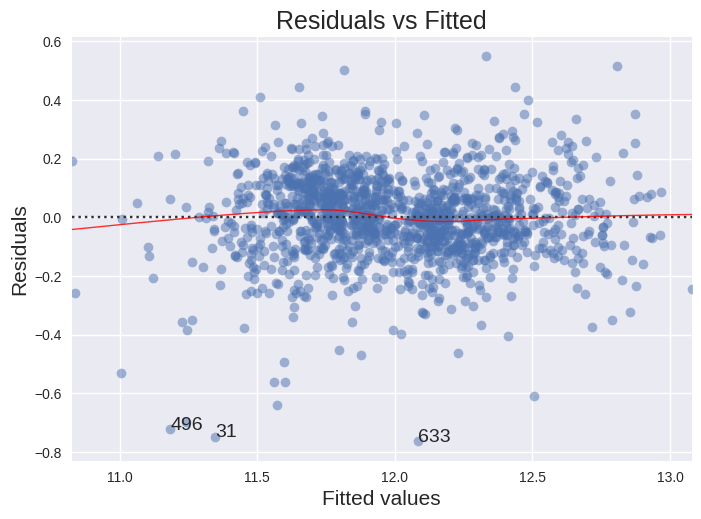

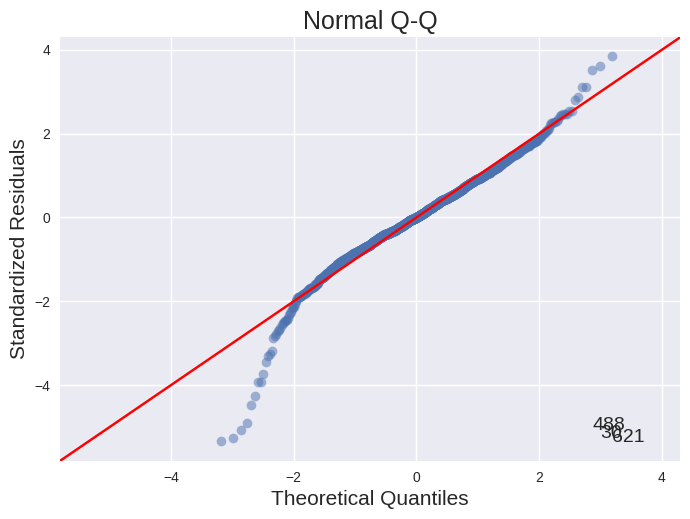

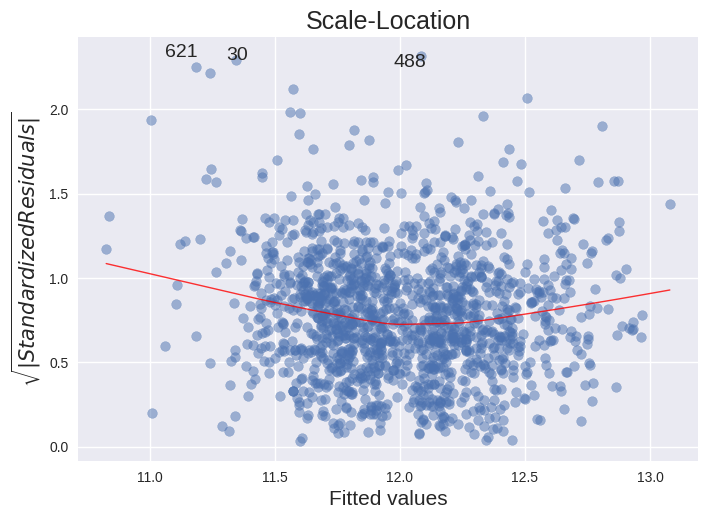

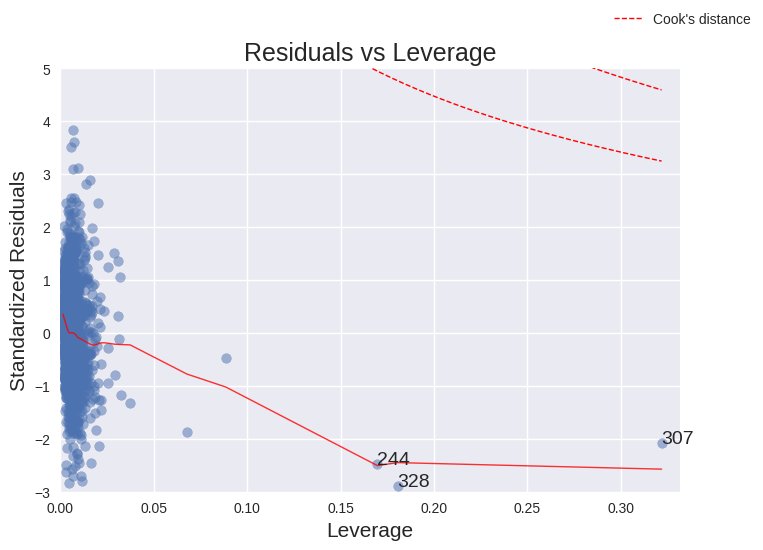

In [245]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

In [246]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.262483
2    12.162523
3    12.313508
4    12.033224
5    12.690265
dtype: float64


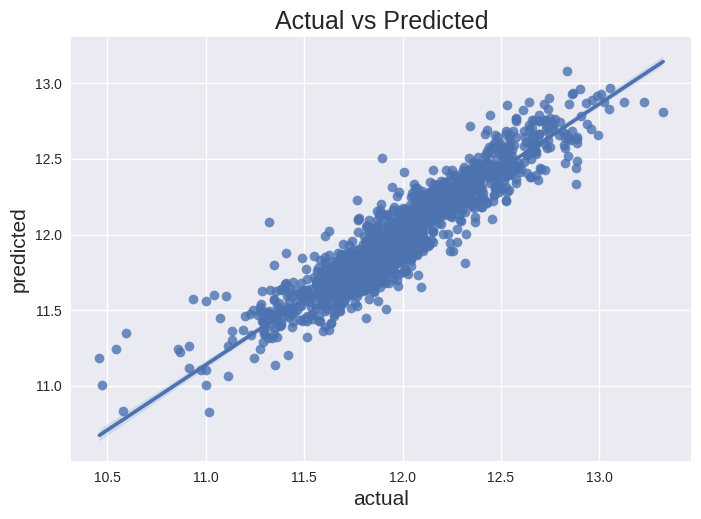

In [247]:
plot_prediction(y, y_pred)

In [248]:
print('Root Mean Square Error (RMSLE) :', rmsle(y, y_pred))

Root Mean Square Error (RMSLE) : 0.011069522326354057


In [249]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.777661
1462    11.874445
1463    12.068809
1464    12.179143
1465    12.270897
dtype: float64


In [250]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('regression_linear_9_columns.csv', index = False)

**Model 2 : note obtenue sur Kaggle : 0.15694**

Nous obtenons avec ce set de variables un résultat un peu meilleur qu'avec la baseline fournie durant notre cours. Il semble que la sélection à 9 variables soit intéressante. Elle est pratique, car ce sont des variables "simples" pour nos analystes et donne des résultats intéressants.


### Model 2 - XGboost

Afin de voir s'il est possible d'obtenir une meilleure prédiction, nous avons regardé si le modèle XGboost nous permettait de mieux tirer parties des 9 variables sélectionnées.
Nous allons utiliser une fonction qui serait utilisées par la librairie optuna pour réaliser l'ajustement du modèle, ici en 50 passes.

In [251]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Features used for XGBoost (reuse the same as previous model or select new ones)
xgb_features = [
    "OverallQual",
    "OverallCond",
    "Neighborhood",
    "GrLivArea",
    "LotArea",
    "YearBuilt",
    "Foundation",
    "TotRmsAbvGrd",
    "GarageArea",
]

X = train_preprocess[xgb_features]
X_val = validation_preprocess[xgb_features]
y = target.copy()

# Use Root Mean Square Logarithmic Error, reuse the rmsle function defined earlier
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Optuna objective function for hyperparameter tuning
def objective(trial):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "alpha": trial.suggest_float("alpha", 1e-6, 10, log=True),
        "lambda": trial.suggest_float("lambda", 1e-6, 10, log=True),
        "random_state": 42,
    }
    model = XGBRegressor(objective="reg:squarederror", **params)
    score = cross_val_score(model, X, y, cv=5, scoring=rmsle_scorer, n_jobs=-1).mean()
    return score

# Launch the optuna study to maximise the params specified in the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(
    "best_params =",
    study.best_params,
    "with cross_validation_score =",
    study.best_value,
)


[I 2025-06-20 22:28:10,515] A new study created in memory with name: no-name-c78e76ce-c24d-4492-ab34-fc2dee9dc38b
[I 2025-06-20 22:28:10,559] Trial 0 finished with value: -0.011943130932823646 and parameters: {'eta': 0.160893254645833, 'n_estimators': 149, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.900717058630323, 'colsample_bytree': 0.8384421857345199, 'gamma': 0.45149568785251193, 'alpha': 1.2808584766384532e-05, 'lambda': 0.04757892188425747}. Best is trial 0 with value: -0.011943130932823646.
[I 2025-06-20 22:28:10,605] Trial 1 finished with value: -0.012034486360440513 and parameters: {'eta': 0.09303210893639838, 'n_estimators': 143, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8637918931388611, 'colsample_bytree': 0.8070389852797346, 'gamma': 0.48539598010054713, 'alpha': 0.31221969622711176, 'lambda': 0.4283103527167766}. Best is trial 0 with value: -0.011943130932823646.
[I 2025-06-20 22:28:10,649] Trial 2 finished with value: -0.011720229319148354 and pa

best_params = {'eta': 0.013650427127497769, 'n_estimators': 733, 'max_depth': 16, 'min_child_weight': 9, 'subsample': 0.6116704992470342, 'colsample_bytree': 0.5736757644363183, 'gamma': 0.025069788971704428, 'alpha': 2.783205147673236e-06, 'lambda': 0.00024105121036459832} with cross_validation_score = -0.010886095018005708


In [252]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [253]:
# Train final model with best params
best_params = study.best_params
model = XGBRegressor(objective='reg:squarederror', **best_params)
model.fit(X, y)

y_pred = model.predict(X)
print("Train RMSLE:", rmsle(y, y_pred))

# Predict on validation set
y_val_pred = model.predict(X_val)
print("Validation predictions (log1p):", y_val_pred[:5])

# Prepare submission
submission = pd.DataFrame()
submission['Id'] = X_val.index
submission['SalePrice'] = np.expm1(y_val_pred)
submission.to_csv('xgboost_optuna.csv', index=False)

Train RMSLE: 0.006812392159731433
Validation predictions (log1p): [11.794117 11.944487 12.098288 12.140412 12.241323]


**Model 2 : note obtenue sur Kaggle : 0.14336**

Nous obtenons une note un peu meilleure que notre premier modèle de régression, toujours avec notre set à 9 variables.

### Model 3 - Decision Tree

Afin d'expérimenter, nous avons effectué une analyse avec un descision tree.

In [254]:
# Create a new model training with optuna and a DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# Features used for XGBoost (reuse the same as previous model or select new ones)
dt_features = [
    "OverallQual",
    "OverallCond",
    "Neighborhood",
    "GrLivArea",
    "LotArea",
    "YearBuilt",
    "Foundation",
    "TotRmsAbvGrd",
    "GarageArea",
]

X = train_preprocess[dt_features]
X_dt = validation_preprocess[dt_features]
y = target.copy()


def objective_tree(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42,
    }
    model = DecisionTreeRegressor(**params)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()
    return score


study_tree = optuna.create_study(direction="maximize")
study_tree.optimize(objective_tree, n_trials=50)

print(
    "best_params =",
    study_tree.best_params,
    "with cross_validation_score =",
    study_tree.best_value,
)

[I 2025-06-20 22:28:15,863] A new study created in memory with name: no-name-be4f5579-1dca-44e4-92ec-5699b3c0de6b
[I 2025-06-20 22:28:15,897] Trial 0 finished with value: -0.18997766861369708 and parameters: {'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 0 with value: -0.18997766861369708.
[I 2025-06-20 22:28:15,920] Trial 1 finished with value: -0.18997766861369708 and parameters: {'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 20}. Best is trial 0 with value: -0.18997766861369708.
[I 2025-06-20 22:28:15,943] Trial 2 finished with value: -0.1880177873175024 and parameters: {'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 2 with value: -0.1880177873175024.
[I 2025-06-20 22:28:15,966] Trial 3 finished with value: -0.187929491952959 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 15}. Best is trial 3 with value: -0.187929491952959.
[I 2025-06-20 22:28:15,989] Trial 4 finished w

best_params = {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 11} with cross_validation_score = -0.18390761852580556


In [255]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [256]:
# Train final model with best params
best_tree_params = study_tree.best_params
model_tree = DecisionTreeRegressor(**best_tree_params)
model_tree.fit(X, y)

y_pred_tree = model_tree.predict(X)
print("Train RMSLE (Decision Tree):", rmsle(y, y_pred_tree))

# Predict on validation set
y_val_pred_tree = model_tree.predict(X_dt)
print("Validation predictions (Decision Tree):", y_val_pred_tree[:5])
# Prepare submission
submission_tree = pd.DataFrame()
submission_tree['Id'] = X_dt.index
submission_tree['SalePrice'] = np.expm1(y_val_pred_tree)
submission_tree.to_csv('decision_tree_optuna.csv', index=False)

Train RMSLE (Decision Tree): 0.01107968474117331
Validation predictions (Decision Tree): [11.71046006 11.95547878 12.08101363 12.08101363 12.19807581]


**Model 3 : note obtenue sur Kaggle : 0.18076**

Ce modèle ne semble pas spécialement bien fonctionner avec nos données et notre use case. On obtient un score kaggle en dessous de notre nos 3 précédents modèles.

## Sythèse de l'analyse

Le set de 9 variables proposées nous semble intéressant en combinaison avec le modèle XGboost. Ce dernier a donné les meilleurs résultats, cela avec un set de variables pratiques à utiliser.
Il serait envisageable de l'utiliser pour aider nos analystes à obtenir des estimations de tarifs immobiliers, le tout avec un relativement petit set d'informations à fournir.

## Cadre juridique et considérations éthiques
Dans un contexte où les banques intègrent de plus en plus l’intelligence artificielle à leurs processus décisionnels, le recours à des modèles prédictifs soulève des enjeux majeurs en matière de responsabilité, d’équité et de conformité. Le projet développé par Banklytics s’inscrit dans cette dynamique, en cherchant à fiabiliser l’évaluation de biens immobiliers proposés en garantie hypothécaire grâce à l’IA, tout en respectant des principes juridiques et éthiques rigoureux.

L’objectif est de s’assurer que le montant d’un prêt hypothécaire n’excède pas la valeur réelle du bien financé, afin de limiter le risque pour la banque en cas de défaut. Pour ce faire, Banklytics a mis au point un modèle de régression supervisée, entraîné sur des données ouvertes (Ames Housing Dataset), capable d’estimer de manière neutre et automatisée le prix de vente attendu d’un bien immobilier. L’estimation algorithmique constitue une aide à la décision pour l’analyste d’octroi de crédit, qui conserve l’entière responsabilité de l’évaluation finale. Cette approche s’inscrit dans une logique de “human-in-the-loop”, conforme aux exigences de redevabilité.

Sur le plan juridique, le projet est soumis aux Fair Lending Laws applicables aux États-Unis, en particulier le Fair Housing Act et l’Equal Credit Opportunity Act (ECOA), qui interdisent toute forme de discrimination directe ou indirecte dans l’accès au crédit. Conformément à ces textes, le modèle exclut l’usage de variables corrélées à des critères protégés (comme le quartier, si ce dernier est susceptible d’introduire des biais géographiques indirects), conformément aux bonnes pratiques en matière de fairness algorithmique (Barocas, Hardt & Narayanan, 2019).

Par ailleurs, si le modèle est utilisé comme un Automated Valuation Model (AVM) dans le processus d’évaluation hypothécaire, il doit respecter les exigences formulées dans les Interagency Appraisal and Evaluation Guidelines (Office of the Comptroller of the Currency, 2010). Celles-ci imposent notamment une documentation complète, la traçabilité des traitements, une auditabilité ex post, et la possibilité d’expliquer chaque estimation en cas de recours client, comme le prévoit également la Regulation B (12 CFR § 1002.9).

Sur le plan de la protection des données, même si le jeu de données utilisé est anonymisé, un déploiement en environnement réel devra se conformer à des régulations comme le California Consumer Privacy Act (CCPA), en assurant la minimisation des données collectées et la transparence des usages. En cas d'expansion des activités au territoire européen, 

À titre volontaire, une analyse comparative a été menée à la lumière de l’AI Act européen (Règlement [UE] 2024/…) dans le but d’anticiper un alignement futur avec les exigences internationales en matière d’IA responsable. Selon l’article 6(2) de l’AI Act, un système d’IA utilisé dans le cadre de l’évaluation de la solvabilité ou de la garantie d’un emprunt relève de la catégorie à haut risque. Le projet répond donc aux obligations prévues aux articles 9 à 15, parmi lesquelles :

- La mise en place d’un système de gestion des risques (art. 9)
- La qualité et représentativité des données utilisées (art. 10)
- Une traçabilité complète des opérations algorithmiques (art. 12)
- Des mécanismes d’explicabilité internes pour les analystes (art. 13)
- L’intégration d’un contrôle humain significatif dans le processus (art. 14)
- Et une robustesse technique, testée régulièrement (art. 15)

Sur le plan éthique, les fondements du projet ont été éclairés par le chargé de cours HES-SO Lev Kiwi sur l’éthique et le droit en science des données, qui rappelle que toute technologie est normative par nature et qu’aucun système d’IA ne peut être considéré comme neutre. Comme l’illustre la citation de Coded Bias (2020) présentée dans le cours :

**“When you think of AI, it's forward-looking. But AI is based on data, and data is a reflection of our history.”**

Cette réflexion justifie le choix d’un cadre rigoureux dès la phase de conception.

Inspiré des grands courants éthiques évoqués dans le support, en particulier l’utilitarisme, le kantisme et le principe du voile d’ignorance de Rawls, le projet veille à maximiser l’utilité pour tous les demandeurs tout en garantissant des règles justes, indépendamment du profil de l’emprunteur. L’équipe Banklytics s’est également référée aux principes de justice sociale et de réduction des inégalités, en intégrant un suivi par segment géographique afin de prévenir toute sous-évaluation systématique de certaines zones ou catégories de biens.

Des outils d’interprétabilité tels que SHAP sont mobilisés pour offrir à l’analyste une visualisation des facteurs influents de chaque prédiction. Cela contribue à une transparence renforcée, condition indispensable au maintien de la confiance des clients comme des régulateurs. Le système ne remplace jamais l’humain, mais le soutient dans ses choix, dans le respect du principe de responsabilité partagée entre l’individu, l’organisation et l’État (Lev Kiwi, 2024).

Enfin, l’auditabilité est assurée par une journalisation des prédictions et une documentation exhaustive. En cas de litige, la banque est en mesure de justifier chaque décision, garantissant un droit à la compréhension et à la contestation, conforme aux standards internationaux de redevabilité algorithmique.

L’ensemble du dispositif mis en place par Banklytics vise ainsi à concilier performance technologique, compliance banquaire et engagements éthiques, en cohérence avec les orientations futures de l’IA à impact sociétal.

## Conclusion / ouverture

Ce cas permet d'explorer comment prédire des tarifs immobiliers pour une région précise des États-Unis. En se limitant a un set de 9 variables, nous pouvons déjà obtenir des prédictions intéressantes.
Cependant, notre cas révèle aussi un certains nombres de limites. Comment collecter des données à plus grande échelle pour faire des prédictions dans tous les USA, voire dans le monde ? Y a-t-il des critères universels que nous pouvons utiliser comme variables pour faire des prédictions tout autour du monde. Ou, à l'inverse, faut-il préparer des modèles spécifiques pour chaque zone géographique et adapter les variables utilisées pour qu'elles correspondent mieux aux critères qui ont du poids dans ces différentes régions.

La fiabilité des prédictions devrait pouvoir être testées avec des cas réels et nouveaux pour avoir une meilleure vision des performances envisageables. Les cas ou un Analyste ne dispose pas de toutes les variables nécessaires au modèle est aussi à étudier. S'il manque régulièrement des variables à nos Analystes, la prédiction devient-elle trop incertaine ?
Il faut aussi questionner la fiabilité des certaines variables. Autant la surface d'un bien peut être bien normée et facile à calculer, qu'en est-il de la "qualité" d'un bien. Si le calcul de cette variable n'est pas fiable, les prédictions seront mécaniquement moins fiables. Aussi, nous ne sommes pas la seule banque, si nous avons des biais dans notre clientèle, par ex. nous avons des majorités d'immeubles dans nos prêts, les prédictions sont elles toujours fiables pour d'autre type de biens immobiliers ? Faudrait-il des modèles spécifiques par catégories de biens ?

La mise à jour des donnés au fil des années doit aussi être étudiée, cela afin de maintenir les performances du modèle au fil des évolutions du marché.

Pour finir, nous avons vu qu'il est possible d'obtenir des prédictions intéressantes avec ce set restreint de données et l'utilisation du modèle XGboost. Ce cas soulève toutefois un certain nombre d'éléments qui devraient être approfondis et étudiés pour permettre de disposer du modèle (ou une suite de modèles) réellement intéressants pour notre banque.

## Références
AI HLEG. (2019). Ethics Guidelines for Trustworthy AI. European Commission.
Barocas, S., Hardt, M., & Narayanan, A. (2019). Fairness and Machine Learning: Limitations and Opportunities. https://fairmlbook.org

Binns, R. (2018). Fairness in Machine Learning: Lessons from Political Philosophy. Proceedings of the 2018 Conference on Fairness, Accountability and Transparency (FAT*).

Friedler, S. A., Scheidegger, C., Venkatasubramanian, S. (2019). The (Im)possibility of Fairness: Different Value Systems Require Different Mechanisms for Fair Decision Making. Communications of the ACM, 64(4), 136–143.

Office of the Comptroller of the Currency. (2010). Interagency Appraisal and Evaluation Guidelines.

Parlement européen & Conseil de l’Union européenne. (2024). Règlement (UE) 2024/XXXX sur une approche harmonisée de l’IA (AI Act).